## **Imports**

In [80]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer,
    OrdinalEncoder,
    LabelEncoder,
    TargetEncoder,
)

## **Paths & Global Variables**

In [81]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"

import sys

sys.path.append(ROOT_PATH)

from titanic.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR
from titanic.eda.univariate_plots import plot_histogram, plot_barchart, plot_boxplot

## **Reading Data**

In [82]:
os.chdir(INTERIM_DATA_DIR)
interim_df = pd.read_parquet("titanic_cleaned.parquet")
interim_df.head(1)

,siblings_spouses,parents_children,num_rooms,age,fare,survived,passenger_class,sex,embarked,cabin_level_1,full_name,ticket,cabin,surname,title,first_name,cabin_level_2,split
passenger_id,,,,,,,,,,,,,,,,,,
1,1,0,0,22.0,7.25,False,Lower,male,S,G,"Braund, Mr. Owen Harris",A/5 21171,Unknown,Braund,Mr,Owen Harris,0,train


In [83]:
interim_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 1 to 1309
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   siblings_spouses  1307 non-null   int64   
 1   parents_children  1307 non-null   int64   
 2   num_rooms         1307 non-null   int64   
 3   age               1307 non-null   float64 
 4   fare              1307 non-null   float64 
 5   survived          1307 non-null   bool    
 6   passenger_class   1307 non-null   category
 7   sex               1307 non-null   category
 8   embarked          1307 non-null   category
 9   cabin_level_1     1307 non-null   category
 10  full_name         1307 non-null   string  
 11  ticket            1307 non-null   string  
 12  cabin             1307 non-null   string  
 13  surname           1307 non-null   string  
 14  title             1307 non-null   string  
 15  first_name        1307 non-null   string  
 16  cabin_level_2     1307 non-nu

# **1. Feature Transformation Methods**

## **Numerical Variables**

### **Standardising**

In [84]:
scale_vars_list = ["age"]

for var in scale_vars_list:
    scaler = StandardScaler()
    interim_df[f"{var}_scaled"] = scaler.fit_transform(interim_df[[var]])

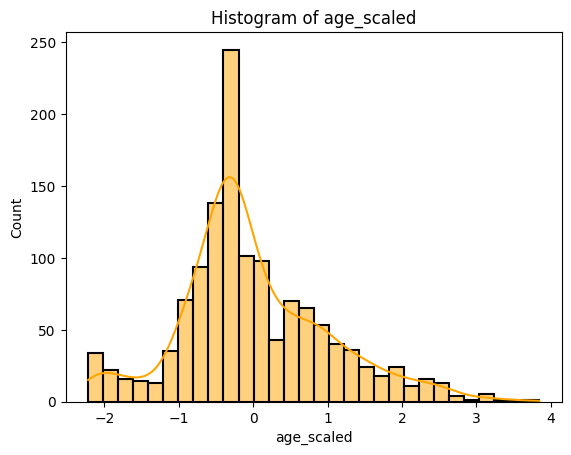

<Figure size 1000x500 with 0 Axes>

In [85]:
plot_histogram(interim_df, "age_scaled", transformed=True)

### **Min-Max Normalisation**

In [86]:
minmax_vars_list = ["age"]

for var in minmax_vars_list:
    scaler = MinMaxScaler()
    interim_df[f"{var}_min_max"] = scaler.fit_transform(interim_df[[var]])

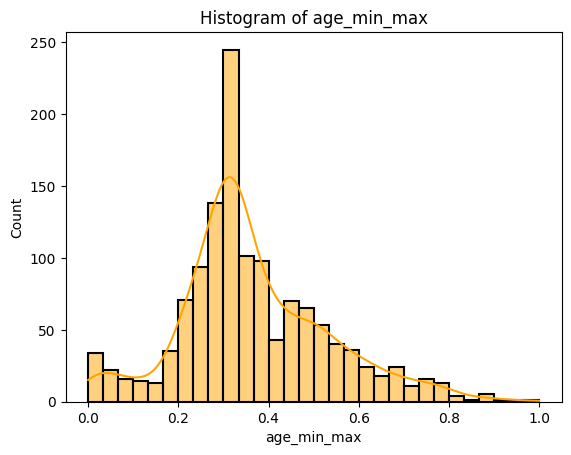

<Figure size 1000x500 with 0 Axes>

In [87]:
plot_histogram(interim_df, "age_min_max", transformed=True)

### **Binning**

In [88]:
# Define the bins and labels
bins = [0, 12, 18, 35, 60, 100]
labels = ["Child", "Teen", "Young Adult", "Adult", "Senior"]

# Create a new column 'age_group' with the binned age data
interim_df["age_group"] = pd.cut(
    interim_df["age"], bins=bins, labels=labels, right=False
)

In [89]:
interim_df["age_group"] = pd.Categorical(
    interim_df["age_group"], categories=labels, ordered=True
)
interim_df["age_group"] = interim_df["age_group"].cat.rename_categories(
    ["Child", "Teen", "Young Adult", "Adult", "Senior"]
)
interim_df["age_group"].unique()

['Young Adult', 'Adult', 'Child', 'Teen', 'Senior']
Categories (5, object): ['Child' < 'Teen' < 'Young Adult' < 'Adult' < 'Senior']

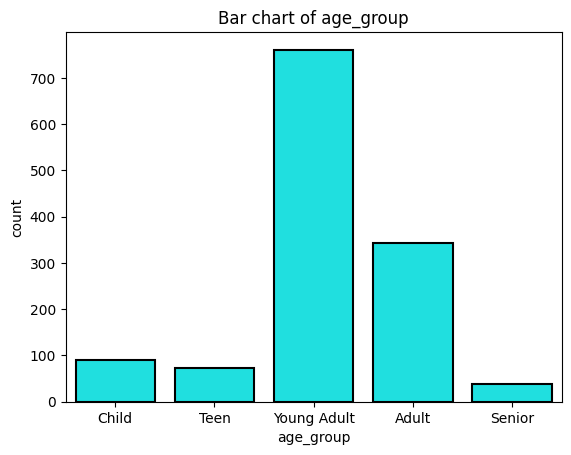

<Figure size 1000x500 with 0 Axes>

In [90]:
plot_barchart(interim_df, "age_group")

### **Natural Log Transformation**

In [91]:
log_vars_list = ["fare"]

for var in log_vars_list:
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    interim_df[f"{var}_log"] = log_transformer.transform(interim_df[[var]])

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


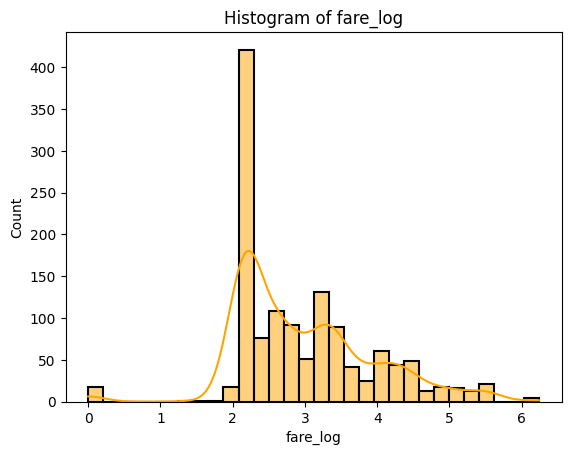

<Figure size 1000x500 with 0 Axes>

In [92]:
plot_histogram(interim_df, "fare_log", transformed=True)

## **Ordinal Variables**

### **Ordinal Encoder**

In [93]:
ordinal_features_dict = {
    "age_group": interim_df["age_group"].unique(),
    "passenger_class": interim_df["passenger_class"].unique(),
}

for feature, labels in ordinal_features_dict.items():
    encoder = OrdinalEncoder(categories=[labels])
    interim_df[f"{feature}_ord"] = encoder.fit_transform(interim_df[[feature]])
    interim_df[f"{feature}_ord"] = interim_df[f"{feature}_ord"].astype("int")
    print(interim_df[f"{feature}_ord"].unique())

[0 1 2 3 4]
[0 1 2]


## **Nominal Variables**

### **Label Encoder**

In [94]:
nom_vars_list = [
    "full_name",
    "surname",
    "title",
    "first_name",
    "cabin",
    "ticket",
    "cabin_level_2",
]

nom_cat_vars_list = [
    "sex",
    "embarked",
    "cabin_level_1",
]

for feature in nom_vars_list + nom_cat_vars_list:
    encoder = LabelEncoder()
    interim_df[f"{feature}_lcode"] = encoder.fit_transform(interim_df[feature])

### **One-Hot Encoding (low cardinality)**

In [95]:
for var in nom_cat_vars_list:
    series = interim_df[var]
    interim_df = pd.get_dummies(data=interim_df, columns=[var], drop_first=True)
    interim_df[var] = series
    print(interim_df[var].unique())

['male', 'female']
Categories (2, object): ['female', 'male']
['S', 'C', 'Q']
Categories (3, object): ['C', 'Q', 'S']
['G', 'C', 'F', 'E', 'D', 'A', 'B']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']


### **Target Encoding (high cardinality)**

In [96]:
for feature in nom_vars_list:
    target_encoder = TargetEncoder()
    interim_df[f"{feature}_target"] = target_encoder.fit_transform(
        interim_df[[feature]], interim_df["survived"]
    )

In [97]:
interim_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 1 to 1309
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   siblings_spouses      1307 non-null   int64   
 1   parents_children      1307 non-null   int64   
 2   num_rooms             1307 non-null   int64   
 3   age                   1307 non-null   float64 
 4   fare                  1307 non-null   float64 
 5   survived              1307 non-null   bool    
 6   passenger_class       1307 non-null   category
 7   full_name             1307 non-null   string  
 8   ticket                1307 non-null   string  
 9   cabin                 1307 non-null   string  
 10  surname               1307 non-null   string  
 11  title                 1307 non-null   string  
 12  first_name            1307 non-null   string  
 13  cabin_level_2         1307 non-null   string  
 14  split                 1307 non-null   object  
 15  age_scale

## **Date Variables**

### **DateTime Encoding**

# **2. Dimensionality Reduction Methods** 🔴

# **3. Feature Selection Methods** 🔴

## **Filter Methods**

## **Wrapper Methods**

## **Embedded Methods**

In [98]:
os.chdir(PROCESSED_DATA_DIR)
interim_df.to_csv("titanic_processed.csv")
interim_df.to_parquet("titanic_processed.parquet")